# Implementation for the qFLO Algorithm

### James D. Watson

# Table of contents
1. [Introduction](#introduction)
2. [Methods](#methods)
    1. [Linear Algebra Functions](#linalg)
    2. [Simulation Functions](#simulation)
    3. [Local Observables](#observable)
3. [Hamiltonian Input from OpenFermion](#openfermion)
4. [qDRIFT Implementation](#qDRIFT)
5. [qFLO Implementation](#qFLO)
    1. [qFLO Example](#linalg)

# Introduction <a name="introduction"></a>

Here we give explicit code for the qFLO algorithm given in https://arxiv.org/abs/2411.04240

# Methods <a name="methods"></a>

## Useful Pauli and Qubit Manipulations

In [1]:
# Imports

import numpy as np
import scipy.interpolate as interp
import scipy.linalg as sla
import numpy.linalg as nla
import matplotlib.pyplot as plt
import random as rand
import pandas as pd
from mpmath import *
from datetime import datetime
from datetime import date

C:\Users\05wat\anaconda3\Lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Computes Kronecker (tensor) product of a list of matrices
# Example:
# Input: [X,Y,Z,Y]
# Return: X \ox Y \ox Z \ox Y
def kron_list(matrix_list):
    result = matrix_list[0]
    for i in range(1,len(matrix_list)):
        result = np.kron(result,matrix_list[i])
        
    return result

# Pauli matrices
I = np.array([[1.,0],[0,1.]], dtype='complex')
X = np.array([[0,1.],[1.,0]], dtype='complex')
Y = np.array([[0,-1.j],[1.j,0]], dtype='complex')
Z = np.array([[1.,0],[0,-1.]], dtype='complex')

# Converts string representation of paulis to list of matrices,
# Example:
# Input: "XYZY"
# Return: [X,Y,Z,Y]
def paulistring_to_list(paulistring): 
    matrix_list = list(paulistring)
    translate = {'I':I, 'X':X, 'Y':Y, 'Z':Z}
    for p in range(len(paulistring)):
        matrix_list[p] = translate[matrix_list[p]]
    return matrix_list

# Computes generalized pauli matrix, given a string in standard form,
# Example:
# Input: "XYZY"
# Return: X \ox Y \ox Z \ox Y
def pauli_matrix(paulistring):
    return kron_list(paulistring_to_list(paulistring))

# Computes generalized pauli matrix, specified by non-identity pieces. Nonidentities encoded as dictionary
# of the form {k:'P', ..., } where k is the integer location and P is a pauli
# Example:
# Input: {0: 'X', 3:'Z', 5:'X'}, 6
# Return: X\ox I \ox  Z \ox I \ox I \ox X
def sparse_pauli(nonidentities, nqubits):
    #starting string is all identity
    paulilist = []
    for i in range(0, nqubits):
        paulilist.append('I')
    
    #Change string to paulis specified by dictionary
    for key in nonidentities:
        paulilist[key] = nonidentities[key]
    paulistring = ''.join(paulilist)
    
    return pauli_matrix(paulistring) 

# Returns the matrix of \sigma . \sigma between sites i and j
# Example:
# Input: 0,1,4
# Return: X\ox X \ox I \ox I + Y\ox Y \ox I \ox I + Z\ox Z \ox I \ox I
def sigma_dot_sigma(i,j,nqubits):
    return sparse_pauli({i:'X',j:'X'},nqubits) + sparse_pauli({i:'Y',j:'Y'},nqubits) + sparse_pauli({i:'Z',j:'Z'},nqubits)

# Qubit computational basis
zero = np.array([1.,0], dtype ='complex')
one = np.array([0,1.], dtype ='complex')

# Converts a bitstring to list of single-qubit kets
# Example: 
# Input: "0101"
# Output: list( (1,0), (0,1), (1,0), (0,1) )
def bitstring_to_list(bitstring):
    bitlist = list(bitstring)
    translate = {'0':zero, '1':one}
    for b in range(len(bitstring)):
        bitlist[b] = translate[bitlist[b]]
    return bitlist

# Converts a bitstring to full vector/array describing each qubit.
# Example: 
# Input: "0101"
# Output:  (1,0) \ox (0,1) \ox (1,0) \ox (0,1) 
def basis_ket(bitstring):
    return kron_list(bitstring_to_list(bitstring))


# Outputs a bit string with certain positions set to 1, and otherwise set to zero.
# Example: 
# Input: [0,1,2],3
# Output:  (0,0,0,0,0,0,0,0,1)
def sparse_bitstring(ones, nqubits):
    bitlist = ['0']*nqubits
    
    #Flip certain bits to one, as specified by list of qubit indices
    for qubit in ones:
        bitlist[qubit] = '1'
    
    # Convert list to bitstring
    bitstring = ''.join(bitlist)
    
    return basis_ket(bitstring)

## Linear Algebra Functions <a name="linalg"></a>

In [3]:
## We are working with large matrix powers. Here we use diagonalisation rather than the repeated square method to compute
## large exponents.
## Code taken from: https://saturncloud.io/blog/numpys-matrixpower-function-understanding-and-addressing-incorrect-results-for-large-exponents/

# Computer n^th power of square, diagonalisable matrix A:
def matrix_power_eigenvalue(A, n):
    #Adjust precision
    #mp.dps = 20
    
    ## Use in-built hi-precision function:
    output =  np.array(mp.powm(A, n).tolist(), dtype=complex)
    
    return output

def matrix_power_eigenvalue_precise(A, n, precision=20):
    #Adjust precision
    mp.dps = precision
    
    
    ## Use in-built hi-precision function:
    #output =  np.array(mp.powm(A, n).tolist(), dtype=complex)
    output =  mp.powm(A, n)
   
    return output

# The old function
def matrix_power_eigenvalue_old(A, n):
   
    
    eigenvalues, eigenvectors = np.linalg.eig(A)
    D = np.diag(eigenvalues**n)
    print(D)
    output = fp.matrix( eigenvectors @ D @ np.linalg.inv(eigenvectors))
    
    
    return output

### Simulation Functions <a name="simulation"></a>

In [4]:
# Given: a positive integer, nqubits, and a list of n floats, hlist
# Generates the 1D Heisenberg chain Hamiltonian specified in the introduction.
def heisenbergH(nqubits, hlist):
    H = sigma_dot_sigma(0,1,nqubits) + hlist[0]*sparse_pauli({0:'Z'}, nqubits)
    for j in range(1, nqubits):
        H += sigma_dot_sigma(j, (j+1)%nqubits, nqubits) + hlist[j]*sparse_pauli({j:'Z'}, nqubits)
    return H

# Given a square matrix H and float T
# Returns the exact time evolution operator e^{-i H T} 
def Uexact(H, T):
    return sla.expm(-1.j*H*T)

## Returns the matrix with high precision exponentiation.
def Uexact_precise(H, T):
    
    #Adjust precision
    mp.dps = 20
    
    Uexact = mp.expm( -1.j*H*T , method='taylor')
    
    
    ## Use in-built hi-precision function:
    output =  np.array(Uexact.tolist(), dtype=complex)
    
    return output


# Computes a single time step of first or second order Trotter
# Terms in Hterms are applied to the state in increasing index (0,1,...,m)
def Utrot_short(Hterms, t, order = 1):
    m = len(Hterms) # number of terms
    result = sla.expm(-1.j*Hterms[m-1]*t)
    if order == 1:  
        for k in range(m-2,-1,-1):
            result = result @ sla.expm(-1.j*Hterms[k]*t)
    
    elif order == 2: 
        for k in range(m-2, -1, -1):
            result = sla.expm(-1.j*Hterms[k]*t/2) @ result @ sla.expm(-1.j*Hterms[k]*t/2)
    else:
        raise ValueError("Not a valid order of Trotter formula: must be 1 or 2")
    return result

# Computes a single time step of first or second order Trotter
# Terms in Hterms are applied to the state in increasing index (0,1,...,m)
def Utrot_short_precise(Hterms, t, order = 1, precision =20):
    
    #Adjust precision
    mp.dps = precision
    
    m = len(Hterms) # number of terms
    result = mp.expm(-1.j*Hterms[m-1]*t)
    if order == 1:  
        for k in range(m-2,-1,-1):
            result = result @ mp.expm(-1.j*Hterms[k]*t)
    
    elif order == 2: 
        for k in range(m-2, -1, -1):
            result = mp.expm(-1.j*Hterms[k]*t/2) @ result @ mp.expm(-1.j*Hterms[k]*t/2)
    else:
        raise ValueError("Not a valid order of Trotter formula: must be 1 or 2")
    return result
    
# Given: a list Hterms of square matrices of same dimension, float T, a (possibly noninteger) number of steps, and order =1,2
# Returns a Trotter evolution of given order and step number, for time T
def Utrot_long(Hterms, T, steps, order = 1):
    single_step = Utrot_short(Hterms, T/steps, order)
    
    integer_steps = int( np.floor(steps) )
    fractional_step = steps - integer_steps
    
    integer_step_evolve = matrix_power_eigenvalue(single_step, integer_steps)
    fractional_step_evolve = sla.fractional_matrix_power(single_step, fractional_step)
    
    total_evolution = integer_step_evolve @ fractional_step_evolve 
    
    return total_evolution

## Above, but high precision
def Utrot_long_precise(Hterms, T, steps, order = 1, precision =20):
    
    #Adjust precision
    mp.dps = precision
    
    
    single_step = Utrot_short_precise(Hterms, T/steps, order)
    
    step_evolve = matrix_power_eigenvalue(single_step, steps)
    #fractional_step_evolve = sla.fractional_matrix_power(single_step, fractional_step)
    
    total_evolution = step_evolve 
    
    return total_evolution

# Local Observable and Expectation Value Functions <a name="observable"></a>

In [5]:
## Define a Local Observable:

## Computes  Hermitian observable, specified by Pauli strings. Input is a list of dictionaries: nonidentities encoded as dictionary
## of the form {k:'P', ..., } where k is the integer location and P is a pauli. Pauli strings are then input as list.
# Example:
# Input: [{0: 'X', 3:'Z', 5:'X'}, {1: 'X'}], 6
# Return: X\ox I \ox  Z \ox I \ox I \ox X + I\ox X \ox  I \ox I \ox I \ox I
def intialise_observable(List_Pauli_strings, nqubits):

    local_observable = 0
    for k in range(len(List_Pauli_strings)):
        local_observable +=  sparse_pauli( List_Pauli_strings[k], nqubits )
    
    return local_observable

## Take expectation value of 'observable' with respect to to 'state'
# Example:
# Input: sparse_bitstring([0], 1), observable([{0: 'Z'}], 1) 
# Output: -1
def expectation_value(state, observable):
    
    normalisation =   np.vdot(state, state )  
    # Throw an exception if the state is not normalised.
    if (normalisation -1) > 0.00001:
        raise ValueError("State is not normalised")
    
    # Calculate the expectation of the state. Use vdot to get complex conjugate.
    expectation = np.vdot(state, observable.dot(state) )
    
    # Throw an exception if there is a significant imaginary part to the expectation value.
    if np.abs(expectation.imag) > 0.00001:
        raise ValueError("Expectation value should be entirely real")
        
    # Return only the real part of the expectation value (imaginary part should be zero).
    return np.real(expectation)

## Finds the expectation value with respect to the Trotterized time evolution. Define the function in terms of s = 1/steps.
# Example: 
# Input: [Even, Odd, Potential], sparse_bitstring([0,1], 2), 10, 0.01, observable([{0: 'Z'}], 2) 
# Output: -1 + 0.j
def Trotterized_Expectation(Hterms, initial_state, time, s, observable, order = 1):
    
    steps = 1/s
    
    # Calculate the Trotterized time-evolution operator and apply to the initial state.
    Trotterized_evolution_operator = Utrot_long(Hterms, time, steps, order)
    time_evolved_state = Trotterized_evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)

## High Precision Version of above.
def Trotterized_Expectation_precise(Hterms, initial_state, time, s, observable, order = 1):
    
    steps = 1/s
    
    # Calculate the Trotterized time-evolution operator and apply to the initial state.
    Trotterized_evolution_operator = Utrot_long_precise(Hterms, time, steps, order)
    time_evolved_state = Trotterized_evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)
    
## Computes the time-evolved expectation value from the *exact* evolution.  
# Example: 
# Input: heisenbergH(nqubits, hlist), sparse_bitstring([0,1], 2), 10, observable([{0: 'Z'}], 2) 
# Output: -1 + 0.j
def Exact_Expectation(Hamiltonian, initial_state, time, observable):
    
    # Calculate the exact evolution operator.
    evolution_operator = Uexact(Hamiltonian, time)
    # Apply the exact evolution to the initial state.
    time_evolved_state = evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)


## Precise version of the above.
def Exact_Expectation_Precise(Hamiltonian, initial_state, time, observable):
    
    # Calculate the exact evolution operator.
    evolution_operator = Uexact_precise(Hamiltonian, time)
    # Apply the exact evolution to the initial state.
    time_evolved_state = evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)


## Computes the magnetisation as a matrix.
# Example:
# Input: 5
# Output: (1/5)\sum_{i=1}^5 Z_i
def Magnetisation(nqubits):
    
    magnetisation_list = []
    
    # For each qubit we want to measure Z on that qubit and then add them together. Generate the Pauli string
    # representing this operator.
    for k in range(nqubits):
        magnetisation_list.append( { k : 'Z'} )
        
    # Calculate the matrix form of the local observable.
    magnetisation_matrix = (1/nqubits)*observable(magnetisation_list, nqubits)
    
    return magnetisation_matrix

# Hamiltonian Input from OpenFermion <a name="openfermion"></a>

In [6]:
### This takes the values stored without going through OpenFermion

#H2
H2_operator = [['-0.16733398905695251', ''], ['-0.046156695889015324', 'X0 X1 Y2 Y3'], ['0.046156695889015324', 'X0 Y1 Y2 X3'], ['0.046156695889015324', 'Y0 X1 X2 Y3'], ['-0.046156695889015324', 'Y0 Y1 X2 X3'], ['0.16251648748871642', 'Z0'], ['0.16583253721590402', 'Z0 Z1'], ['0.11720364720195847', 'Z0 Z2'], ['0.1633603430909738', 'Z0 Z3'], ['0.16251648748871642', 'Z1'], ['0.1633603430909738', 'Z1 Z2'], ['0.11720364720195847', 'Z1 Z3'], ['-0.19744293699755816', 'Z2'], ['0.17169788392286725', 'Z2 Z3'], ['-0.19744293699755816', 'Z3']]

#LiH
LiH_operator = [['-7.49894690201071', ''], ['-0.0029329964409502266', 'X0 X1 Y2 Y3'], ['0.0029329964409502266', 'X0 Y1 Y2 X3'], ['0.01291078027311749', 'X0 Z1 X2'], ['-0.0013743761078958677', 'X0 Z1 X2 Z3'], ['0.011536413200774975', 'X0 X2'], ['0.0029329964409502266', 'Y0 X1 X2 Y3'], ['-0.0029329964409502266', 'Y0 Y1 X2 X3'], ['0.01291078027311749', 'Y0 Z1 Y2'], ['-0.0013743761078958677', 'Y0 Z1 Y2 Z3'], ['0.011536413200774975', 'Y0 Y2'], ['0.16199475388004184', 'Z0'], ['0.011536413200774975', 'Z0 X1 Z2 X3'], ['0.011536413200774975', 'Z0 Y1 Z2 Y3'], ['0.12444770133137588', 'Z0 Z1'], ['0.054130445793298836', 'Z0 Z2'], ['0.05706344223424907', 'Z0 Z3'], ['0.012910780273117487', 'X1 Z2 X3'], ['-0.0013743761078958677', 'X1 X3'], ['0.012910780273117487', 'Y1 Z2 Y3'], ['-0.0013743761078958677', 'Y1 Y3'], ['0.16199475388004186', 'Z1'], ['0.05706344223424907', 'Z1 Z2'], ['0.054130445793298836', 'Z1 Z3'], ['-0.013243698330265966', 'Z2'], ['0.08479609543670981', 'Z2 Z3'], ['-0.013243698330265952', 'Z3']]

In [7]:
## Functions for converting outputs of the Hamiltonian to the 

# Remove the identity terms to get only the non-trivial terms.
def remove_identity(Hamiltonian):
    reduced_Hamiltonian = Hamiltonian
    for element in reduced_Hamiltonian:
        if element[1]=='':
            reduced_Hamiltonian.remove(element)

    return reduced_Hamiltonian
            
# Convert the openfermion operator to our form.
# Input: [['-0.5', 'X0 X1 Y2 Y3'], ['2', 'X0 Y1 Y2 X3']]
# Output: [[-0.5, {0: 'X', 1: 'X', 2: 'Y', 3: 'Y'}], [2, {0: 'X', 1: 'Y', 2: 'Y', 3: 'X'}]]
def openfermion_to_local_rep(of_Hamiltonian):
    local_representation = []
    for element in of_Hamiltonian:
        coefficient     = float(element[0]) 
        element_strings = element[1].split(' ')
        local_operator  = {}
        for op_string in element_strings:
            local_operator[int(op_string[1])]=op_string[0]

        local_representation.append( [ coefficient, local_operator  ] )

    return local_representation

# Transforms into explicit matrix representation.
# Takes input from openfermion_to_local_rep
def local_matrix_representation(local_rep_Hamiltonian, nqubits):
    matrix_representation = []
    for element in local_rep_Hamiltonian:
        matrix_representation.append( [element[0], sparse_pauli(element[1], nqubits)])

    return matrix_representation

# Generates the full explicit matrix of the Hamiltonian.
def explicit_Hamiltonian_matrix(local_matrix_representation):
    Hamiltonian_matrix = 0
    for element in local_matrix_representation:
        Hamiltonian_matrix += element[0]*element[1]

    return Hamiltonian_matrix


In [8]:
## Tests
test_op = remove_identity(H2_operator)

new_rep = openfermion_to_local_rep(test_op)

local_mat_rep = local_matrix_representation(new_rep, 4)

Hamiltonian_matrix = explicit_Hamiltonian_matrix(local_mat_rep)
#print(len(test_op))
#print(Hamiltonian_matrix)

# qDRIFT Implementation <a name="qDRIFT"></a>

In [9]:
import random

## Takes a list of coefficients and terms and then sums them cummulatively.
def cumulative_Hamiltonian_rep(local_rep_Hamiltonian):
    running_total = 0
    cumulative_representation = []
    
    for element in local_rep_Hamiltonian:
        running_total += np.abs( element[0] )
        cumulative_representation.append( [ running_total,  element[1] ] )

    return cumulative_representation


# Samples an index with probability proportional to weight.
def sample_local_index(local_rep_Hamiltonian, no_samples):
    """
    Samples an index from the array with a probability proportional to the absolute value of the number.

    Parameters:
        arr (list): List of numbers (can be positive or negative).

    Returns:
        int: Index of the sampled number.
    """
    
    # Compute the absolute values
    abs_values = [abs(x[0]) for x in local_rep_Hamiltonian]
    

    # Compute the total sum of absolute values
    total_abs = sum(abs_values)

    if total_abs == 0:
        raise ValueError("The sum of absolute values in the array must not be zero.")

    # Compute probabilities
    probabilities = [value / total_abs for value in abs_values]

    # Sample an index based on probabilities
    sampled_index = random.choices(range(len(abs_values)), weights=probabilities, k=no_samples)

    return sampled_index 


# Single shot calculation of expectation values.
def qDRIFT_observable(local_rep_Hamiltonian, initial_state, observable, nqubits, time, no_timesteps, matrix_input = 0):

    if matrix_input == 1:
        local_mat_rep = local_rep_Hamiltonian
    elif matrix_input ==0:
        #local_mat_rep = local_rep_Hamiltonian 
        local_mat_rep = local_matrix_representation(local_rep_Hamiltonian, nqubits)
               
    temp = [abs(element[0]) for element in local_mat_rep]
    lambda_param = sum(temp)
    
    # Now generate the corresponding terms.
    list_of_indicies = sample_local_index(local_mat_rep, int(no_timesteps) )

    state = initial_state
    timestep = time/no_timesteps
    
    for index in list_of_indicies:
        state = sla.expm(-(1j)*timestep*lambda_param*np.sign(local_mat_rep[index][0])*(local_mat_rep[index][1])) @ state

    expectation = expectation_value(state, observable)

    return expectation


# Average the qDRIFT values over multiple runs.
def qDRIFT_average(local_rep_Hamiltonian, initial_state, observable, nqubits, time, no_timesteps, shot_no, matrix_input = 0):
    """
    Takes average over multiple qDRIFT runs.
    """
    results_array = []
    j = 0
    while j<= shot_no:
        results_array.append(qDRIFT_observable(local_rep_Hamiltonian, initial_state, observable, nqubits, time, no_timesteps, matrix_input = matrix_input))
        j += 1

    mean = sum(results_array)/len(results_array)

    return mean

    

#### Short Test Case for qDRIFT

In [677]:
### Implement H2 Time evolution.

H2_operator  = remove_identity(H2_operator)
H2_local_rep = openfermion_to_local_rep(H2_operator)


cumulative_H2_Hamiltonian = cumulative_Hamiltonian_rep(H2_local_rep)
lambda_param = cumulative_H2_Hamiltonian[-1][0]

nqubits = 4
time =0.5
#observable = intialise_observable([{0: 'X', 2:'Z', 3:'Z'}, {1: 'X'}, {2:'Y'},{3:'Y'}, {3:'Z'}, {0:'Z', 1:'X'}, {0:'Z', 2:'Z'}], nqubits)
observable = intialise_observable([{0:'Y', 1:'Y'}, {1:'Z'}, {2:'Y', 3:'Z'}, {3:'Z'}], nqubits)
state = (1/np.sqrt(2))*np.array(sparse_bitstring([nqubits//2], nqubits))+ (1/np.sqrt(2))*np.array(sparse_bitstring([1], nqubits))
#state = (1/np.sqrt(2))*np.array(sparse_bitstring([0,2], 4))+(1/np.sqrt(2))*np.array(sparse_bitstring([1,3], 4))
#state  = np.array(sparse_bitstring([0,2], 4))
epsilon = 0.03
no_timesteps = np.ceil( 2*time**2*lambda_param**2/epsilon )


#test_val = qDRIFT_observable(H2_local_rep , state, observable, nqubits, time, no_timesteps )

test_avg = qDRIFT_average(H2_local_rep , state, observable, nqubits, time, no_timesteps, 50 )
print("avg:", test_avg)

avg: 0.9969838120524056


In [678]:
## True value from perfect evolution:
#state = (1/np.sqrt(2))*np.array(sparse_bitstring([nqubits//2], nqubits))+ (1/np.sqrt(2))*np.array(sparse_bitstring([1], nqubits))
#state = np.array(sparse_bitstring([0,2], 4))
#state = (1/np.sqrt(2))*np.array(sparse_bitstring([0,2], 4))+(1/np.sqrt(2))*np.array(sparse_bitstring([1,3], 4))
full_H2_Hamiltonian = 0
H2_list = local_matrix_representation(H2_local_rep, nqubits)
for element in H2_list:
    full_H2_Hamiltonian += element[0]*element[1]


final_state = sla.expm(-(1j)*time*np.matrix(full_H2_Hamiltonian)) @ state
perfect_val  = expectation_value(final_state, observable)

print("Ideal value:", perfect_val)

Ideal value: 0.9999999999999998


In [679]:
## Check against Trotterisation

hterms = [ x[0]*x[1] for x in  local_mat_rep ]

print("Value from Trotterization:", Trotterized_Expectation(hterms, state, time, 1/no_timesteps, observable, order = 1))

Value from Trotterization: 1.0000000000000497


# qFLO Implementation <a name="qFLO"></a>

In [10]:
### Here implement the qFLO procedure.    
def richardson_points(order, s_min, type = "standard"):
    
    #Generate the array of points we wish to use:
    points_array = []
    values_array = []
    coefficient_array = []
    estimate_array = []
    estimate = 0
    x_array = []
    y_array = []
    R_scale = np.sqrt(8)*order/np.pi

    if type ==  "standard":
        for j in range( order):
            counter = j+1
            #Generate points to be sampled from.
            ## Define parameters used for rescaling:
            x0 = (np.sin(np.pi*(2*order-1)/(4*2*order) ))**2
            y0 = np.ceil( np.ceil(  R_scale/np.sqrt(x0))**2 )
        
            # Calculate the points to sample from.
            x_array.append( (np.sin(np.pi*(2*counter-1)/(4*2*order) ))**2 )
            y_array.append( np.ceil( (1/s_min)*np.ceil(  R_scale/np.sqrt(x_array[j]) )**2 /y0  )) 
            print(x_array, "Sampled points",y_array)
            #Generate expectation values at those points.
    elif type == "short":
        for j in range( order):
            counter = j+1
            #Generate points to be sampled from.
            ## Define parameters used for rescaling:
            x0 = (np.sin(np.pi*(2*order-1)/(4*2*order) ))**2
            y0 = np.ceil( np.ceil(  R_scale/np.sqrt(x0)) )
        
            # Calculate the points to sample from.
            x_array.append( (np.sin(np.pi*(2*counter-1)/(4*2*order) ))**2 )
            y_array.append( np.ceil( (1/s_min)*np.ceil(  R_scale/np.sqrt(x_array[j]) ) /y0  )) 
            print(x_array, "Sampled points",y_array)
            #Generate expectation values at those points.

    return y_array

def richardson_estimate(order, s_min, Hamiltonian_local_rep, initial_state, time, observable, nqubits , shot_no, sample_points = "standard", circuit_depth_flag= 0, matrix_flag  = 0):
    '''
    Construct a Richardson estimator using the terms starting from s_min. 
    '''
    #Generate the array of points we wish to use:
    points_array = []
    values_array = []
    coefficient_array = []
    estimate_array = []
    estimate = 0
    x_array = []
    y_array = []
    R_scale = np.sqrt(8)*order/np.pi

    # Evaluate function at generated points
    y_array = richardson_points(order, s_min, type = sample_points)
    for no_timesteps in y_array:
        #print("Number timesteps:", no_timesteps)
        points_array.append(no_timesteps)
        if matrix_flag == 1:
            qDRIFT_val   = qDRIFT_average( Hamiltonian_local_rep, initial_state, observable, nqubits, time, no_timesteps, shot_no, matrix_input = 1 )
        elif matrix_flag == 0:
            qDRIFT_val   = qDRIFT_average( Hamiltonian_local_rep, initial_state, observable, nqubits, time, no_timesteps, shot_no, matrix_input = 0 )
        print("qDRIFT value:",qDRIFT_val)
        values_array.append( qDRIFT_val )
        maximum_circuit_depth = max(points_array)
    
    #Now generate the coefficients (b_j)
    coefficient_array = Richardson_coefficient_finder(points_array, order)
    #print("Coeff array", coefficient_array)
    print("Depth array",points_array)
    '''
    #Now generate the coefficients (b_j).
    for j in range(order):
        counter = j+1
        coefficient = 1
        for k in range(order):
            if k != j:
                print(y_array[k],y_array[j])
                coefficient = coefficient*(1/(1-y_array[k]/y_array[j]))
        coefficient_array.append( coefficient )
    '''

    # Compute the Richardson estimator.
    for j in range(order):
        estimate += coefficient_array[j]*values_array[j]
        estimate_array.append(estimate)

    print("coefficient array:", coefficient_array)
    
    if circuit_depth_flag == 0:
        return estimate

    if circuit_depth_flag == 1:
        return [estimate, maximum_circuit_depth]


# Given a list of sample points, returns the Vandermode matrix.
def Vandermode_generator(points_list, order):

    Vandermode_matrix = []

    inverse_list = [1/x for x in points_list]
    
    # Now fill in the samples.
    for j in range(order):
        Vandermode_matrix.append([])
        [Vandermode_matrix[j].append(x**(j)) for x in inverse_list ]

    Vandermode_matrix = np.array( Vandermode_matrix )
    return Vandermode_matrix


# Find Richardson extrapolation coefficients.
def Richardson_coefficient_finder(points_list, order):
    
    # Generate the Vandermode matrix.
    V = Vandermode_generator(points_list, order)

    # Now solve for vector of a's.
    single_element    = [0]*order
    single_element[0] = 1
    single_element    = np.array(single_element)

    a_array = np.linalg.inv(V) @ single_element

    return a_array

## Alternative Implementation using code from ChatGPT

In [11]:
## From chatgpt

def richardson_extrapolation_gpt(x_values, f_values):
    """
    Estimate the value of f(0) using Richardson extrapolation.

    Parameters:
        x_values (list or numpy array): Non-zero x values.
        f_values (list or numpy array): Corresponding evaluations of f(x).

    Returns:
        float: The estimated value of f(0).
    """
  
    
    if len(x_values) != len(f_values):
        raise ValueError("x_values and f_values must have the same length.")

    n = len(x_values)
    if n < 2:
        raise ValueError("At least two points are required for Richardson extrapolation.")

    # Sort x_values and f_values by the absolute value of x_values
    indices = np.argsort(np.abs(x_values))
    x_values = np.array(x_values)[indices]
    f_values = np.array(f_values)[indices]

    # Create a matrix for extrapolation
    table = np.zeros((n, n))
    table[:, 0] = f_values

    for j in range(1, n):
        for i in range(n - j):
            factor = (x_values[i + j] / x_values[i])**(2 * j)
            table[i, j] = (factor * table[i + 1, j - 1] - table[i, j - 1]) / (factor - 1)

    # The top-left corner of the table is the extrapolated value for f(0)
    return table[0, n - 1]


## Generates the samples
def gpt_estimator(order, s_min, Hamiltonian_local_rep, initial_state, time, observable, nqubits , shot_no, circuit_depth_flag= 0):

    #Generate the array of points we wish to use:
    points_array = []
    values_array = []
    coefficient_array = []
    estimate_array = []
    estimate = 0
    x_array = []
    y_array = []
    R_scale = np.sqrt(8)*order/np.pi

    # Evaluate function at generated points
    y_array = richardson_points(order, s_min)
    for no_timesteps in y_array:
        print("Number timesteps:", no_timesteps)
        points_array.append(no_timesteps)
        qDRIFT_val   = qDRIFT_average( Hamiltonian_local_rep, initial_state, observable, nqubits, time, no_timesteps, shot_no )
        print("qDRIFT value:",qDRIFT_val)
        values_array.append( qDRIFT_val )
        maximum_circuit_depth = max(points_array)

    x_values = y_array
    f_values = values_array

    estimator = richardson_extrapolation_gpt(x_values, f_values)
    return estimator
    

In [695]:
# Test Richardson Extrapolation with H2 Hamiltonian.
no_timesteps = np.ceil( 2*time**2*lambda_param**2/epsilon )
s_min   = 10/no_timesteps
shot_no = 2000
order = 2
#state = (1/np.sqrt(2))*np.array(sparse_bitstring([nqubits//2], nqubits))+ (1/np.sqrt(2))*np.array(sparse_bitstring([1], nqubits))
state = (1/np.sqrt(2))*np.array(sparse_bitstring([0,2], 4))+(1/np.sqrt(2))*np.array(sparse_bitstring([1,3], 4))


qFLO_estimate = richardson_estimate(order, s_min, H2_local_rep, state, time, observable, nqubits , shot_no)
print("qFLO Estimate:", qFLO_estimate)

[0.03806023374435662] Sampled points [35.0]
[0.03806023374435662, 0.3086582838174551] Sampled points [35.0, 6.0]
qDRIFT value: -0.00036195785507477
qDRIFT value: 0.00025916747211959167
Depth array [35.0, 6.0]
coefficient array: [ 1.20689655 -0.20689655]
qFLO Estimate: -0.0004904665434598103


In [696]:
#order = 2, depth =35
order2 = np.mean([0.0016889253945332424, 0.0007455795529319857, -0.0004904665434598103])
#order = 4, depth =210
#order = 3, depth =98
order3 = np.mean([-0.0003229052959175927, -0.0002581859115869328, 0.0003344804204041113])
#order = 4, depth =210
order4 = np.mean([0.0003499931879853918, 0.0001538310742211319, -0.0004434020267358443])

In [697]:
print(order2, order3, order4)

0.0006480128013351393 -8.220359570013803e-05 2.014074515689313e-05


## qFLO Example Usage: LiH <a name="example"></a>

In [669]:
# Here we provide an example with the correct parameters to evaluate performance.

LiH_operator  = remove_identity(LiH_operator)
LiH_local_rep = openfermion_to_local_rep(LiH_operator)
cumulative_LiH_Hamiltonian = cumulative_Hamiltonian_rep(LiH_local_rep)
lambda_param = cumulative_LiH_Hamiltonian[-1][0]

## Parameters to use.
qubits = 4
epsilon = 0.05
time    = 1
shot_no = 1000
#shot_no = 1/epsilon**2
s_min   = 1/np.ceil( 2*time**2*lambda_param**2/epsilon )
observable = intialise_observable([{0: 'X', 2:'Z', 3:'Z'}, {1: 'X'}, {2:'X'},{3:'X'}, {3:'Z'}, {0:'Z', 1:'X'}], nqubits)
#state   = (1/np.sqrt(2))*np.array(sparse_bitstring([nqubits//2], nqubits))+ (1/np.sqrt(2))*np.array(sparse_bitstring([1], nqubits))
state = (1/np.sqrt(2))*np.array(sparse_bitstring([0,2], 4))+(1/np.sqrt(2))*np.array(sparse_bitstring([1,3], 4))
max_order = 3



## Compute ideal expectation value:
state   = (1/np.sqrt(2))*np.array(sparse_bitstring([nqubits//2], nqubits))+ (1/np.sqrt(2))*np.array(sparse_bitstring([1], nqubits))
#state = (1/np.sqrt(2))*np.array(sparse_bitstring([0,2], 4))+(1/np.sqrt(2))*np.array(sparse_bitstring([1,3], 4))
full_LiH_Hamiltonian = 0
for element in H2_list:
    full_LiH_Hamiltonian += element[0]*element[1]

final_state  = sla.expm(-(1j)*time*np.matrix(full_LiH_Hamiltonian)) @ state
#perfect_val  = expectation_value(final_state, observable)
perfect_val  = expectation_value(final_state, local_obs)

print("Ideal value:", perfect_val)

Ideal value: 2.999999999999999


In [673]:
error_array = []
circuit_depth_array = []
shot_no = 1000

for order in range(1,max_order+1):
    [LiH_qFLO_estimate, max_circuit_depth] = richardson_estimate(order, s_min, LiH_local_rep, state, time, local_obs, nqubits , shot_no, circuit_depth_flag=1)
    print("qFLO Estimate", LiH_qFLO_estimate)
    circuit_depth_array.append(max_circuit_depth)
    error = abs(perfect_val - LiH_qFLO_estimate)
    error_array.append(error)

[0.14644660940672624] Sampled points [33.0]
qDRIFT value: 2.989807194703638
Depth array [33.0]
coefficient array: [1.]
qFLO Estimate 2.989807194703638
[0.03806023374435662] Sampled points [207.0]
[0.03806023374435662, 0.3086582838174551] Sampled points [207.0, 33.0]
qDRIFT value: 2.9948384367565466
qDRIFT value: 2.989051946979186
Depth array [207.0, 33.0]
coefficient array: [ 1.18965517 -0.18965517]
qFLO Estimate 2.9959358744729427
[0.01703708685546585] Sampled points [583.0]
[0.01703708685546585, 0.14644660940672624] Sampled points [583.0, 85.0]
[0.01703708685546585, 0.14644660940672624, 0.37059047744873963] Sampled points [583.0, 85.0, 33.0]
qDRIFT value: 2.99544363753619
qDRIFT value: 2.993216625466947
qDRIFT value: 2.9891317678534
Depth array [583.0, 85.0, 33.0]
coefficient array: [ 1.24092369 -0.27900062  0.03807692]
qFLO Estimate 2.9958246387030987


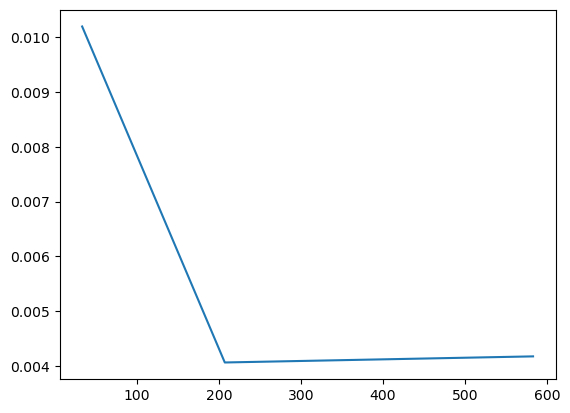

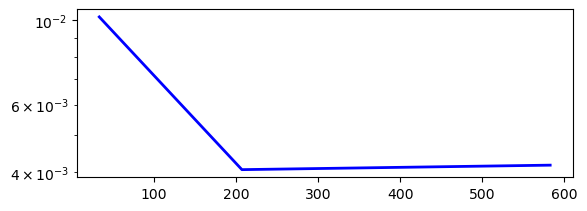

In [675]:
import matplotlib.pyplot as plt

fig = plt.plot(circuit_depth_array, error_array)  # Plot the chart
fig = plt.figure()
ax = fig.add_subplot(2,1,1)

line, = ax.semilogy(circuit_depth_array,error_array, color='blue', lw=2)


## Defining Heisenberg Hamiltonian

In [13]:
## Define the even, odd and potential terms for an arbitrary nunber of qubits and a given hlist.

def Even_Heisenberg_Terms(nqubits):
    Even = sigma_dot_sigma(0, 1, nqubits)
    for j in range(2,nqubits,2):
        Even += sigma_dot_sigma(j, (j+1)%nqubits, nqubits)
        
    return Even

def Odd_Heisenberg_Terms(nqubits):
    
    Odd = sigma_dot_sigma(1, 2%nqubits, nqubits)
    for j in range(3,nqubits,2):
        Odd += sigma_dot_sigma(j, (j+1)%nqubits, nqubits)
        
        
    return Odd

def Potential_Heisenberg_Terms(nqubits, hlist):
    
    Potential = np.sum([hlist[j]*sparse_pauli({j:'Z'}, nqubits) for j in range(nqubits)], axis = 0)
        
    return Potential





# Trial With Heisenberg Hamiltonian

## Initialise the Heisenberg Hamiltonian

In [35]:
## Initialise a set of Hamiltonian 

# System parameters.
nqubits = 3
h = 3 # Maximum single qubit potential strength

# Define the Hamiltonian and the groupings of its terms.
#hlist = (np.random.rand(nqubits)*2 -1)*h
hlist = np.array([-0.4125828165944454, -2.4009870302222223, 2.623614294609909])
Hterms_Heisenberg = [Even_Heisenberg_Terms(nqubits), Odd_Heisenberg_Terms(nqubits), Potential_Heisenberg_Terms(nqubits, hlist)]
Htot = np.sum(Hterms_Heisenberg, axis = 0)


# Choose local observable and initial state
state = sparse_bitstring([nqubits//2], nqubits)
#local_obs = Htot 

local_obs_array1= [{0: 'Z'},{nqubits-1: 'Z'}, {1: 'X'} ]
local_obs_array2= [{0: 'X'}, {1:'Y'}, {nqubits-1: 'I'}]
local_obs = intialise_observable(local_obs_array1, nqubits) + intialise_observable(local_obs_array2, nqubits)
#local_obs_array= [{0: 'X'}, {1:'Y'}, {nqubits-1: 'I'}]
#local_obs = intialise_observable(local_obs_array, nqubits)

In [36]:
Heisenberg_matrix_rep = [[6, (1/6)*Hterms_Heisenberg[0]], [6, (1/6)*Hterms_Heisenberg[1]], [sla.norm(Hterms_Heisenberg[2],2), 1/sla.norm(Hterms_Heisenberg[2],2)*Hterms_Heisenberg[2]]]


Htot2 = Even_Heisenberg_Terms(nqubits) +  Odd_Heisenberg_Terms(nqubits) + Potential_Heisenberg_Terms(nqubits, hlist)

In [37]:
time = 0.1

final_state = sla.expm(-(1j)*time*np.array(Htot)) @ state
perfect_val_Heisenberg  = expectation_value(final_state, local_obs)

print("Ideal value:", perfect_val_Heisenberg) 

Ideal value: 2.8485479319264555


In [34]:
## Check against Trotterisation
lambda_param = 0
for element in Heisenberg_matrix_rep:
    lambda_param += element[0]

epsilon = 0.05
time = 0.1
no_timesteps = np.ceil( 2*time**2*lambda_param**2/epsilon )
s_min   = 1/no_timesteps


print("Value from Trotterization:", Trotterized_Expectation(Hterms_Heisenberg, state, time, 1/no_timesteps, local_obs, order = 1))

Value from Trotterization: 2.8485476835059904


## Give an alternative Hamiltonian breakdown

In [28]:
## qDRIFT Simulation Attempt 2
# Add the Heisenberg terms separately to the list (i.e. using the standard qDRIFT representation).


new_Heis_rep = []
for j in range(nqubits):
    new_Heis_rep.append(  [1 ,sparse_pauli({j:'X',(j+1)%nqubits:'X'},nqubits)])
    new_Heis_rep.append([1 ,sparse_pauli({j:'Y',(j+1)%nqubits:'Y'},nqubits)])
    new_Heis_rep.append([1 ,sparse_pauli({j:'Z',(j+1)%nqubits:'Z'},nqubits)])

counter = 0
for entry in hlist:
    new_Heis_rep.append( [entry, sparse_pauli({counter:'Z'},nqubits)] )
    counter += 1


In [29]:
shot_no = 100
lambda_param = 0
for element in new_Heis_rep:
    lambda_param += abs(element[0])

Heis_val_new = qDRIFT_average(new_Heis_rep, state, local_obs, nqubits, time, no_timesteps, shot_no, matrix_input = 1)


print("qDRIFT Value:", Heis_val_new)

KeyboardInterrupt: 

In [30]:
# Compare the above to Trotterized Implementation

Heis_terms_Trotter = [ term[0]*term[1] for term in new_Heis_rep]

trotter_val_2 = Trotterized_Expectation(Heis_terms_Trotter, state, time, 1/no_timesteps, local_obs, order = 1)
print("Value from Trotterization:", trotter_val_2)

Value from Trotterization: 2.848547931896674


In [707]:
# Compare with the idealised evolution.

Htot3 = np.sum(Heis_terms_Trotter, axis = 0)

final_state = sla.expm(-(1j)*time*np.array(Htot3)) @ state
perfect_Heis_val  = expectation_value(final_state, local_obs)

print("Ideal value:", perfect_Heis_val) 

Ideal value: 2.8485479319264555


## qFLO Applied to Heisenberg Model

In [38]:
lambda_param = 0
for element in Heisenberg_matrix_rep:
    lambda_param += element[0]

time = 0.5
epsilon = 0.1
no_timesteps = np.ceil( 2*time**2*lambda_param**2/epsilon )
s_min   = 1/no_timesteps
# Choose local observable and initial state
state = sparse_bitstring([nqubits//2], nqubits)
#local_obs = Htot 

Htot3 = np.sum(Heis_terms_Trotter, axis = 0)

final_state = sla.expm(-(1j)*time*np.array(Htot3)) @ state
perfect_Heis_val  = expectation_value(final_state, local_obs)

print("Ideal value:", perfect_Heis_val) 

Ideal value: 1.7180958903720314


In [937]:
error_array_3 = []
circuit_depth_array = []
shot_no = 700
max_order = 4

for order in range(1,max_order+1):
    [Heis_qFLO_estimate_est, max_circuit_depth] = richardson_estimate(order, s_min, new_Heis_rep, state, time, local_obs, nqubits , shot_no, circuit_depth_flag=1, matrix_flag = 1)
    print("qFLO Estimate", Heis_qFLO_estimate_est)
    circuit_depth_array.append(max_circuit_depth)
    error = abs(perfect_Heis_val - Heis_qFLO_estimate_est)
    error_array_3.append(error)


[0.14644660940672624] Sampled points [1525.0]
qDRIFT value: 1.703544966783349
Depth array [1525.0]
coefficient array: [1.]
qFLO Estimate 1.703544966783349
[0.03806023374435662] Sampled points [9532.0]
[0.03806023374435662, 0.3086582838174551] Sampled points [9532.0, 1525.0]
qDRIFT value: 1.7149039713296819
qDRIFT value: 1.709728801561173
Depth array [9532.0, 1525.0]
coefficient array: [ 1.19045835 -0.19045835]
qFLO Estimate 1.7158896256193006
[0.01703708685546585] Sampled points [26901.0]
[0.01703708685546585, 0.14644660940672624] Sampled points [26901.0, 3904.0]
[0.01703708685546585, 0.14644660940672624, 0.37059047744873963] Sampled points [26901.0, 3904.0, 1525.0]
qDRIFT value: 1.7174083909738918
qDRIFT value: 1.7133882384553498
qDRIFT value: 1.7093265333014127
Depth array [26901.0, 3904.0, 1525.0]
coefficient array: [ 1.24005943 -0.2785826   0.03852318]
qFLO Estimate 1.7182169967018825
[0.009607359798384776] Sampled points [57993.0]
[0.009607359798384776, 0.08426519384872735] Sample

In [941]:
#qDRIFT_val_array = [1.7105774524320174, 1.710829002241367,1.7203958752879562,1.7168784054468735]
#qDRIFT_val_array = [1.7057999081145516, 1.7193109295679616, 1.718069151142176, 1.7165611189706185]
#qDRIFT_val_array2 = [1.7123953287728637,1.7181350451650246,1.7125577724003702,1.7165611189706185]
qDRIFT_val_array = [1.703544966783349, 1.7149039713296819, 1.7174083909738918, 1.7175627521443502]
qDRIFT_error_array=[ abs(x -perfect_Heis_val) for x in  qDRIFT_val_array]
#qDRIFT_error_array=[ abs(x -perfect_Heis_val) for x in  qDRIFT_val_array2]


Text(0.5, 1.0, 'Error at Different Circuit Depths')

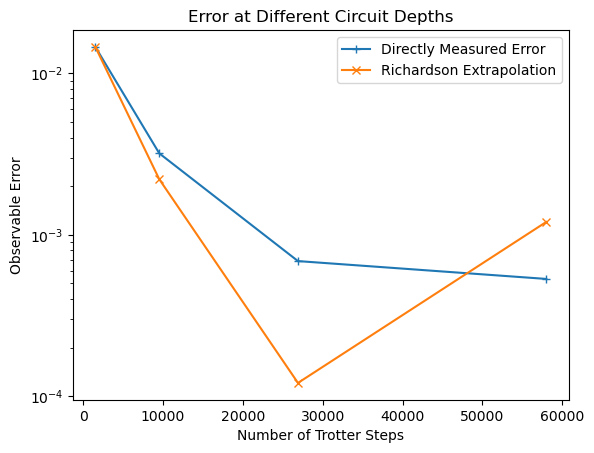

In [942]:
plt.semilogy(circuit_depth_array, qDRIFT_error_array, label="Directly Measured Error", marker = '+')
plt.semilogy(circuit_depth_array, error_array_3,  label="Richardson Extrapolation", marker = 'x')

plt.xlabel('Number of Trotter Steps')
plt.ylabel('Observable Error')
plt.legend()
plt.title("Error at Different Circuit Depths")

In [944]:
### Print the data to file ###

### Export data to Excel for future use:
list_of_arrays = []
# Make string out of state description.
initial_state_string = ''
initial_state_string = [initial_state_string + str(k) for k in sparse_bitstring([nqubits//2], nqubits)]
initial_state_string = ''.join(initial_state_string)

# Initialise arrays.
List_Params   = [None] * max(len(circuit_depth_array), nqubits)
Params_Values = [None] * max(len(circuit_depth_array), nqubits)
hlist_string  = [None] * max(len(circuit_depth_array), nqubits)
obs_string    = [None] * max(len(circuit_depth_array), nqubits)

# Put hlist in correctly formatted array.
for k in range(len(hlist)):
    hlist_string[k] = hlist[k]
    
# Put obs_string in correctly formatted array.    
for k in range(len(local_obs_array)):
    obs_string[k] = local_obs_array[k]

# Input the values of the parameters.    
List_Params[0] = 'Simulation Time'
List_Params[1] = 'Number Qubits'
List_Params[2] = 'Initial State String'
List_Params[3] = 'Shot Number'
Params_Values[0] = time
Params_Values[1] = nqubits
Params_Values[2] = initial_state_string
Params_Values[3] = shot_no

list_of_arrays = list_of_arrays + [circuit_depth_array, error_array_3, qDRIFT_error_array, hlist_string, obs_string, List_Params, Params_Values ]
padded_arrays  = padding_function(list_of_arrays)

# Print data:
data = {'Trotter_Depth_qFLO': padded_arrays[0],
        'Richardson_Extrapolated_Error': padded_arrays[1],
        'qDRIFT': padded_arrays[2],
        'hlist': padded_arrays[3], 
        'Observable Strings': padded_arrays[4], 
        'List_of_Parameters': padded_arrays[5],
        'Parameter_Values': padded_arrays[6],
        }

df = pd.DataFrame(data)

now = datetime.now()
current_time = now.strftime("%H.%M.%S")

file_location_name = r'Data_Sheets\A_qFLO_Heisenberg'+'_'+str(date.today())+'_'+current_time+'.csv'
df.to_csv(file_location_name, index=False)

In [39]:
part_val = qDRIFT_average( new_Heis_rep, state, local_obs, nqubits, time, no_timesteps, 100, matrix_input = 1 )
part_val

1.7086863765364282

In [40]:
## Generate lots of shots of the qDRIFT formula for graph plotting.

no_of_runs = 20
qDRIFT_hyper_array = []
qDRIFT_hyper_error_array = []
sample_points = [57993, 26901, 9532, 1525]
shot_no = 200

for j in range(no_of_runs):
    temp_array = []
    temp_error_array=[]
    for no_timesteps in sample_points:
        temp_val = qDRIFT_average( new_Heis_rep, state, local_obs, nqubits, time, no_timesteps, shot_no, matrix_input = 1 )
        temp_array.append(temp_val)
        temp_error_array.append( abs(temp_val - perfect_Heis_val))
        print("Flag1")
    
    qDRIFT_hyper_array.append(temp_array)
    qDRIFT_hyper_error_array.append(temp_error_array)
    print("Flag2")
        
    



In [41]:
### Export the hyper arrays for future use.
### Export data to Excel for future use:
list_of_arrays = []
# Make string out of state description.
initial_state_string = ''
initial_state_string = [initial_state_string + str(k) for k in sparse_bitstring([nqubits//2], nqubits)]
initial_state_string = ''.join(initial_state_string)

# Initialise arrays.
List_Params   = [None] * max(len(circuit_depth_array), nqubits)
Params_Values = [None] * max(len(circuit_depth_array), nqubits)
hlist_string  = [None] * max(len(circuit_depth_array), nqubits)
obs_string    = [None] * max(len(circuit_depth_array), nqubits)

# Put hlist in correctly formatted array.
for k in range(len(hlist)):
    hlist_string[k] = hlist[k]
    
# Put obs_string in correctly formatted array.    
for k in range(len(local_obs_array)):
    obs_string[k] = local_obs_array[k]

# Input the values of the parameters.    
List_Params[0] = 'Simulation Time'
List_Params[1] = 'Number Qubits'
List_Params[2] = 'Initial State String'
List_Params[3] = 'Shot Number'
Params_Values[0] = time
Params_Values[1] = nqubits
Params_Values[2] = initial_state_string
Params_Values[3] = shot_no

[[1.7147687067805915,
  1.720413735790582,
  1.715018115507904,
  1.7102693055169789],
 [1.7200781418388527,
  1.717713232311346,
  1.7222950569746516,
  1.7185219483602965],
 [1.7174869848073575,
  1.716149587998982,
  1.7173890711243458,
  1.714136925905604],
 [1.7186351285570918,
  1.7194228897294837,
  1.718653584426185,
  1.7041926721676623],
 [1.718261971108836,
  1.7187284448315576,
  1.7185735517920553,
  1.6898079040454907],
 [1.7208518374472892,
  1.7183189895669682,
  1.711477274041528,
  1.7159766354833323],
 [1.721850330790406, 1.720770705947517, 1.7231405965708098, 1.697552112898082],
 [1.7195979027403714,
  1.7158077097240951,
  1.7140760054956476,
  1.7152193465843582],
 [1.7170158378525684,
  1.7154024504054388,
  1.7130377337203262,
  1.689704865664558],
 [1.7178594933664766,
  1.719610247076349,
  1.7163730286204706,
  1.7041331230422958],
 [1.7176403811917915,
  1.718695745112246,
  1.7131461251755573,
  1.702972274668168],
 [1.719122898861967,
  1.7194984966085476,

## Graph A Generation

In [883]:
error_array_graph_A = []
circuit_depth_array_graph_A = []
shot_no = 300
max_order = 3

for order in range(1,max_order+1):
    [Heis_qFLO_estimate_est, max_circuit_depth] = richardson_estimate(order, s_min, new_Heis_rep, state, time, local_obs, nqubits , shot_no, circuit_depth_flag=1, matrix_flag = 1)
    print("qFLO Estimate", Heis_qFLO_estimate)
    circuit_depth_array_graph_A.append(max_circuit_depth)
    error = abs(perfect_Heis_val - Heis_qFLO_estimate_est)
    error_array_graph_A.append(error)



[0.14644660940672624] Sampled points [15246.0]
qDRIFT value: 2.96048385557277
Depth array [15246.0]
coefficient array: [1.]
qFLO Estimate 2.99838202864841
[0.03806023374435662] Sampled points [95288.0]
[0.03806023374435662, 0.3086582838174551] Sampled points [95288.0, 15246.0]
qDRIFT value: 2.960548128336472
qDRIFT value: 2.9604876594408567
Depth array [95288.0, 15246.0]
coefficient array: [ 1.190475 -0.190475]
qFLO Estimate 2.99838202864841
[0.01703708685546585] Sampled points [268940.0]
[0.01703708685546585, 0.14644660940672624] Sampled points [268940.0, 39030.0]
[0.01703708685546585, 0.14644660940672624, 0.37059047744873963] Sampled points [268940.0, 39030.0, 15246.0]
qDRIFT value: 2.9605615702842516
qDRIFT value: 2.96052280955868
qDRIFT value: 2.960425676069341
Depth array [268940.0, 39030.0, 15246.0]
coefficient array: [ 1.24006013 -0.27858283  0.0385227 ]
qFLO Estimate 2.99838202864841


In [888]:
## qDRIFT generation
qDRIFT_graph_A_errors = []
#qDRIFT_graph_A_values = [2.998320519650663, 2.9983760736584992, 2.998415755658372]
#qDRIFT_graph_A_values = [2.998331181628076,2.9983631377251116,2.998393266586436]
#qDRIFT_graph_A_values = [2.998291735202711,2.998370293702979,2.9983944152747237]
#qDRIFT_graph_A_values = [2.998266825985793, 2.998392767973904, 2.9983913553379544] 
#qDRIFT_graph_A_values = [2.998270195542337,2.99839468606558,2.998398309935554]
#qDRIFT_graph_A_values = [2.998392779866826,2.998393906492554,2.998398367874338]
qDRIFT_graph_A_values = [2.96048385557277,2.960548128336472, 2.9605615702842516]

for val in qDRIFT_graph_A_values:
    qDRIFT_graph_A_errors.append(abs(val - perfect_Heis_val) )
    

Text(0.5, 1.0, 'Error at Different Circuit Depths')

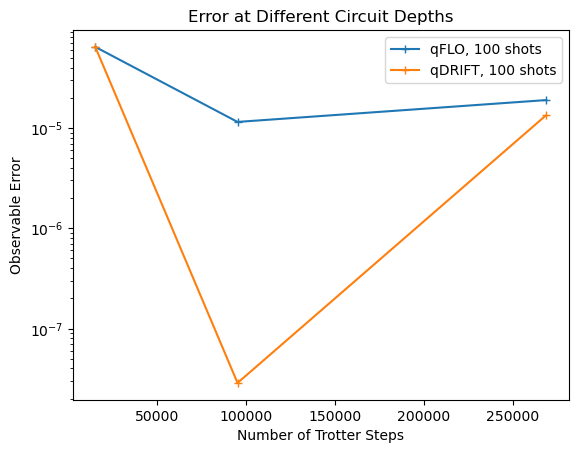

In [900]:
## Including generate the 

#graph_A_circuit_depths = [204, 1275, 3599]


plt.semilogy(circuit_depth_array_graph_A, error_array_graph_A, label="qFLO, 100 shots", marker = '+')
plt.semilogy(circuit_depth_array_graph_A, qDRIFT_graph_A_errors, label="qDRIFT, 100 shots", marker = '+')


plt.xlabel('Number of Trotter Steps')
plt.ylabel('Observable Error')
plt.legend()
plt.title("Error at Different Circuit Depths")

In [886]:
### Print the data to file ###

### Export data to Excel for future use:
list_of_arrays = []
# Make string out of state description.
initial_state_string = ''
initial_state_string = [initial_state_string + str(k) for k in sparse_bitstring([nqubits//2], nqubits)]
initial_state_string = ''.join(initial_state_string)

# Initialise arrays.
List_Params   = [None] * max(len(circuit_depth_array), nqubits)
Params_Values = [None] * max(len(circuit_depth_array), nqubits)
hlist_string  = [None] * max(len(circuit_depth_array), nqubits)
obs_string    = [None] * max(len(circuit_depth_array), nqubits)

# Put hlist in correctly formatted array.
for k in range(len(hlist)):
    hlist_string[k] = hlist[k]
    
# Put obs_string in correctly formatted array.    
for k in range(len(local_obs_array)):
    obs_string[k] = local_obs_array[k]

# Input the values of the parameters.    
List_Params[0] = 'Simulation Time'
List_Params[1] = 'Number Qubits'
List_Params[2] = 'Initial State String'
List_Params[3] = 'Shot Number'
Params_Values[0] = time
Params_Values[1] = nqubits
Params_Values[2] = initial_state_string
Params_Values[3] = shot_no

list_of_arrays = list_of_arrays + [graph_A_circuit_depths, error_array_graph_A, qDRIFT_graph_A_errors, hlist_string, obs_string, List_Params, Params_Values ]
padded_arrays  = padding_function(list_of_arrays)

# Print data:
data = {'Trotter_Depth_qFLO': padded_arrays[0],
        'Richardson_Extrapolated_Error': padded_arrays[1],
        'qDRIFT': padded_arrays[2],
        'hlist': padded_arrays[3], 
        'Observable Strings': padded_arrays[4], 
        'List_of_Parameters': padded_arrays[5],
        'Parameter_Values': padded_arrays[6],
        }

df = pd.DataFrame(data)

now = datetime.now()
current_time = now.strftime("%H.%M.%S")

file_location_name = r'Data_Sheets\A_qFLO_Heisenberg'+'_'+str(date.today())+'_'+current_time+'.csv'
#df.to_excel(file_location_name, index=False)
df.to_csv(file_location_name, index=False)

## Other Stuff

In [632]:
## Now plot vanilla qDRIFT.
qDRIFT_error_array = []

qDRIFT_array = [2.9984003685712626, ]
for element in qDRIFT_array:
    qDRIFT_error_array.append(abs(element - perfect_Heis_val))
    

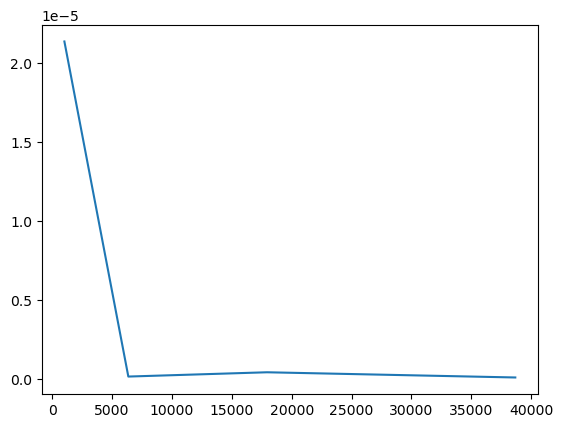

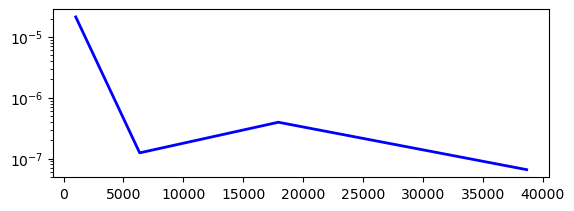

In [753]:
import matplotlib.pyplot as plt

fig = plt.plot(circuit_depth_array, error_array)  # Plot the chart
fig = plt.figure()
ax = fig.add_subplot(2,1,1)

line, = ax.semilogy(circuit_depth_array,error_array, color='blue', lw=2)

## Graph C Generation

In [816]:
## Now plot vanilla qDRIFT.
qDRIFT_array_100 = []
error_array_100 = []

#qDRIFT_array   = [2.9984003685712626, 2.9983999495873745, 2.9983972873620814, 2.9983795108895626]
#qDRIFT_array   = [2.9983873288687737, 2.998395098595048, 2.998390458978316, 2.9983998707590693]
#qDRIFT_array_3 = [2.998403940079874, 2.9983977228437872, 2.99840516960022,2.998403170314654]

qDRIFT_100 = [2.9983873288687737, 2.998395098595048, 2.998390458978316, 2.9983998707590693]
#qFLO_100 = [2.99838202864841, 2.99838202864841, 2.99838202864841, 2.99838202864841]
qFLO_100 = [2.9983873288687737, 2.998395098595048*1.19044944 -2.9983822107615836*0.19044944, 2.998390458978316*1.24009633 -   0.27860758*2.9983840990253814 +0.03851125*2.998391427864963, 2.9983998707590693*1.22912547 - 0.28803556*2.998392476709777+ 0.06830672*2.9983880523273254 -0.00939663*2.998375557374063]

for element in qDRIFT_100:
    qDRIFT_array_100.append(abs(element - perfect_Heis_val))

for element in qFLO_100:
    error_array_100.append(abs(element - perfect_Heis_val))


qDRIFT_array_10000 = [2.1373454322848318e-05, 3.5969818039660595e-06, 9.347565108619449e-07, 5.157726228333104e-07]

#error_array_100 = [2.1373454322848318e-05, 1.2413519501208725e-07, 2.2577578547778103e-07, 6.573681510246843e-08]
#error_array_100 = 
error_array_10000 = [2.1373454322848318e-05, 1.2413519501208725e-07, 3.9577578547778103e-07, 6.573681510246843e-08] 

#qDRIFT_error_array_2.reverse()


ValueError: x and y must have same first dimension, but have shapes (0,) and (4,)

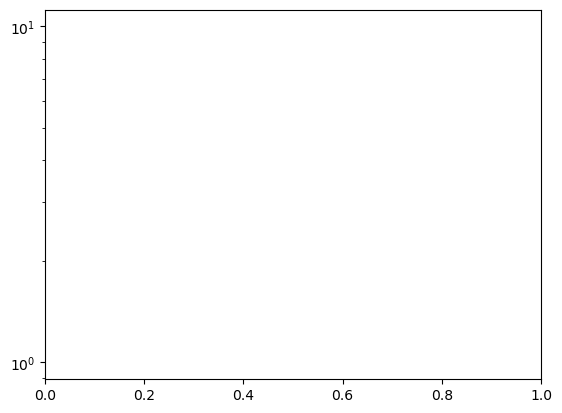

In [901]:
circuit_depth_aray = [38675.0, 4775.0, 1808.0, 1017.0]

plt.semilogy(circuit_depth_array, qDRIFT_array_100, label="Directly Measured qDRIFT, 100 shots", marker = '+')
plt.semilogy(circuit_depth_array, qDRIFT_array_10000, label="Directly Measured qDRIFT, 10000 shots", marker = '+')
plt.semilogy(circuit_depth_array, error_array_10000,  label="Richardson Extrapolation 10000, shots", marker = 'x')
plt.semilogy(circuit_depth_array, error_array_100,  label="Richardson Extrapolation 100, shots", marker = 'x')

plt.xlabel('Number of Trotter Steps')
plt.ylabel('Observable Error')
plt.legend()
plt.title("Error at Different Circuit Depths")

In [768]:
### Print the data to file ###

### Export data to Excel for future use:
list_of_arrays = []
# Make string out of state description.
initial_state_string = ''
initial_state_string = [initial_state_string + str(k) for k in sparse_bitstring([nqubits//2], nqubits)]
initial_state_string = ''.join(initial_state_string)

# Initialise arrays.
List_Params   = [None] * max(len(circuit_depth_array), nqubits)
Params_Values = [None] * max(len(circuit_depth_array), nqubits)
hlist_string  = [None] * max(len(circuit_depth_array), nqubits)
obs_string    = [None] * max(len(circuit_depth_array), nqubits)

# Put hlist in correctly formatted array.
for k in range(len(hlist)):
    hlist_string[k] = hlist[k]
    
# Put obs_string in correctly formatted array.    
for k in range(len(local_obs_array)):
    obs_string[k] = local_obs_array[k]

# Input the values of the parameters.    
List_Params[0] = 'Simulation Time'
List_Params[1] = 'Number Qubits'
List_Params[2] = 'Initial State String'
List_Params[3] = 'Shot Number'
Params_Values[0] = time
Params_Values[1] = nqubits
Params_Values[2] = initial_state_string
Params_Values[3] = shot

list_of_arrays = list_of_arrays + [circuit_depth_array,error_array, qDRIFT_error_array_2, hlist_string, obs_string, List_Params, Params_Values ]
padded_arrays  = padding_function(list_of_arrays)

# Print data:
data = {'Trotter_Depth_qFLO': padded_arrays[0],
        'Richardson_Extrapolated_Error': padded_arrays[1],
        'qDRIFT': padded_arrays[2],
        'hlist': padded_arrays[3], 
        'Observable Strings': padded_arrays[4], 
        'List_of_Parameters': padded_arrays[5],
        'Parameter_Values': padded_arrays[6],
        }

df = pd.DataFrame(data)

now = datetime.now()
current_time = now.strftime("%H.%M.%S")

file_location_name = r'Data_Sheets\B_qFLO_Heisenberg_Precision_Limited'+'_'+str(date.today())+'_'+current_time+'.csv'
#df.to_excel(file_location_name, index=False)
df.to_csv(file_location_name, index=False)

In [820]:
### Print the multi-shot number values to a file:

### Print the data to file ###

### Export data to Excel for future use:
list_of_arrays = []
# Make string out of state description.
initial_state_string = ''
initial_state_string = [initial_state_string + str(k) for k in sparse_bitstring([nqubits//2], nqubits)]
initial_state_string = ''.join(initial_state_string)

# Initialise arrays.
List_Params   = [None] * max(len(circuit_depth_array), nqubits)
Params_Values = [None] * max(len(circuit_depth_array), nqubits)
hlist_string  = [None] * max(len(circuit_depth_array), nqubits)
obs_string    = [None] * max(len(circuit_depth_array), nqubits)

# Put hlist in correctly formatted array.
for k in range(len(hlist)):
    hlist_string[k] = hlist[k]
    
# Put obs_string in correctly formatted array.    
for k in range(len(local_obs_array)):
    obs_string[k] = local_obs_array[k]

# Input the values of the parameters.    
List_Params[0] = 'Simulation Time'
List_Params[1] = 'Number Qubits'
List_Params[2] = 'Initial State String'
#List_Params[3] = 'Shot Number'
Params_Values[0] = time
Params_Values[1] = nqubits
Params_Values[2] = initial_state_string
#Params_Values[3] = shot_no

list_of_arrays = list_of_arrays + [circuit_depth_array,error_array_100, error_array_10000,qDRIFT_array_100, qDRIFT_array_10000, hlist_string, obs_string, List_Params, Params_Values ]
padded_arrays  = padding_function(list_of_arrays)

# Print data:
data = {'Trotter_Depth_qFLO': padded_arrays[0],
        'qFLO_100': padded_arrays[1],
        'qFLO_10000': padded_arrays[2],
        'qDRIFT_100': padded_arrays[3],
        'qDRIFT_10000': padded_arrays[4],
        'hlist': padded_arrays[5], 
        'Observable Strings': padded_arrays[6], 
        'List_of_Parameters': padded_arrays[7],
        'Parameter_Values': padded_arrays[8],
        }

df = pd.DataFrame(data)

now = datetime.now()
current_time = now.strftime("%H.%M.%S")

file_location_name = r'Data_Sheets\C_qFLO_Heisenberg_Precision_Comparison'+'_'+str(date.today())+'_'+current_time+'.csv'
#df.to_excel(file_location_name, index=False)
df.to_csv(file_location_name, index=False)

## Generating Graphs for Paper

In [623]:
### Functions that are useful for outputting the graph. 

# This ensures all lists are output with the same length.
def padding_function(list_of_arrays):

    max_length = max([len(x) for x in list_of_arrays])

    for element in list_of_arrays:
        while len(element) < max_length:
            element.append(None)

    return list_of_arrays
    
        

In [754]:
### Print the data to file ###

### Export data to Excel for future use:
list_of_arrays = []
# Make string out of state description.
initial_state_string = ''
initial_state_string = [initial_state_string + str(k) for k in sparse_bitstring([nqubits//2], nqubits)]
initial_state_string = ''.join(initial_state_string)

# Initialise arrays.
List_Params   = [None] * max(len(circuit_depth_array), nqubits)
Params_Values = [None] * max(len(circuit_depth_array), nqubits)
hlist_string  = [None] * max(len(circuit_depth_array), nqubits)
obs_string    = [None] * max(len(circuit_depth_array), nqubits)

# Put hlist in correctly formatted array.
for k in range(len(hlist)):
    hlist_string[k] = hlist[k]
    
# Put obs_string in correctly formatted array.    
for k in range(len(local_obs_array)):
    obs_string[k] = local_obs_array[k]

# Input the values of the parameters.    
List_Params[0] = 'Simulation Time'
List_Params[1] = 'Number Qubits'
List_Params[2] = 'Initial State String'
Params_Values[0] = time
Params_Values[1] = nqubits
Params_Values[2] = initial_state_string

list_of_arrays = list_of_arrays + [circuit_depth_array,error_array,hlist_string, obs_string, List_Params, Params_Values ]
padded_arrays  = padding_function(list_of_arrays)

# Print data:
data = {'Trotter_Depth_qFLO': padded_arrays[0],
        'Richardson_Extrapolated_Error': padded_arrays[1],
        'hlist': padded_arrays[2], 
        'Observable Strings': padded_arrays[3], 
        'List_of_Parameters': padded_arrays[4],
        'Parameter_Values': padded_arrays[5],
        }

df = pd.DataFrame(data)

now = datetime.now()
current_time = now.strftime("%H.%M.%S")

file_location_name = r'Data_Sheets\A_qFLO_Heisenberg'+'_'+str(date.today())+'_'+current_time+'.csv'
#df.to_excel(file_location_name, index=False)
df.to_csv(file_location_name, index=False)

In [895]:
error_array = []
circuit_depth_array = []
max_order = 4
shot_no = 100000
time = 0.01

for order in range(1,max_order+1):
    [Heis_qFLO_estimate, max_circuit_depth] = richardson_estimate(order, s_min, new_Heis_rep, state, time, local_obs, nqubits , shot_no, circuit_depth_flag=1, matrix_flag = 1)
    print("qFLO Estimate", Heis_qFLO_estimate)
    circuit_depth_array.append(max_circuit_depth)
    error = abs(perfect_Heis_val - Heis_qFLO_estimate)
    error_array.append(error)

[0.14644660940672624] Sampled points [15246.0]


KeyboardInterrupt: 

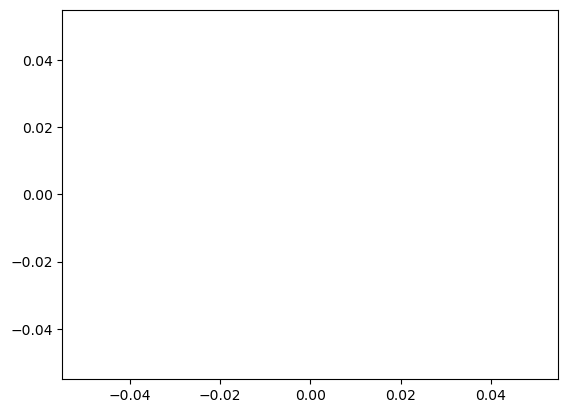

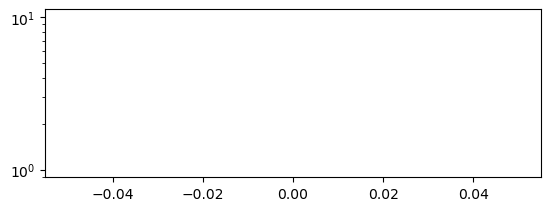

In [896]:
import matplotlib.pyplot as plt

fig = plt.plot(circuit_depth_array, error_array)  # Plot the chart
fig = plt.figure()
ax = fig.add_subplot(2,1,1)

line, = ax.semilogy(circuit_depth_array,error_array, color='blue', lw=2)

In [723]:
## Using a different set of sampling points

time = 0.1
epsilon = 0.001
no_timesteps = np.ceil( 2*time**2*lambda_param**2/epsilon )
s_min   = 1/no_timesteps
# Choose local observable and initial state
state = sparse_bitstring([nqubits//2], nqubits)
shot_no = 1000
#local_obs = Htot 


error_array_short = []
circuit_depth_array_short = []
max_order = 3

for order in range(1,max_order+1):
    [Heis_qFLO_estimate, max_circuit_depth] = richardson_estimate(order, s_min, new_Heis_rep, state, time, local_obs, nqubits , shot_no, sample_points = "short", circuit_depth_flag=1, matrix_flag = 1)
    print("qFLO Estimate", Heis_qFLO_estimate)
    circuit_depth_array_short.append(max_circuit_depth)
    error = abs(perfect_Heis_val - Heis_qFLO_estimate)
    error_array_short.append(error)

[0.14644660940672624] Sampled points [204.0]
qDRIFT value: 2.8393902153574637
Depth array [204.0]
coefficient array: [1.]
qFLO Estimate 2.8393902153574637
[0.03806023374435662] Sampled points [510.0]
[0.03806023374435662, 0.3086582838174551] Sampled points [510.0, 204.0]
qDRIFT value: 2.8442027211629584
qDRIFT value: 2.8366754891805432
Depth array [510.0, 204.0]
coefficient array: [ 1.66666667 -0.66666667]
qFLO Estimate 2.8492208758179016
[0.01703708685546585] Sampled points [857.0]
[0.01703708685546585, 0.14644660940672624] Sampled points [857.0, 327.0]
[0.01703708685546585, 0.14644660940672624, 0.37059047744873963] Sampled points [857.0, 327.0, 204.0]
qDRIFT value: 2.8462375190796316
qDRIFT value: 2.841461033993585
qDRIFT value: 2.838865241296325
Depth array [857.0, 327.0, 204.0]
coefficient array: [ 2.12213297 -1.64026691  0.51813394]
qFLO Estimate 2.8502524021810753


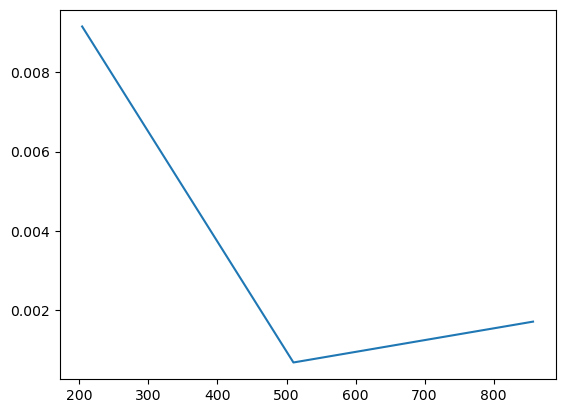

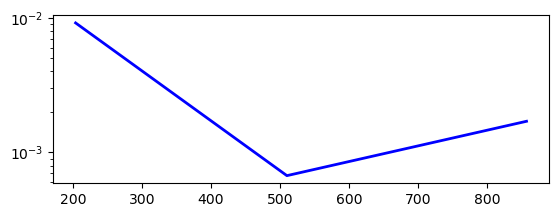

In [724]:
import matplotlib.pyplot as plt

fig = plt.plot(circuit_depth_array_short, error_array_short)  # Plot the chart
fig = plt.figure()
ax = fig.add_subplot(2,1,1)

line, = ax.semilogy(circuit_depth_array_short,error_array_short, color='blue', lw=2)

In [894]:
graph_A_circuit_depths 

[204, 1275, 3599]

In [899]:
error_array_graph_A = error_array_graph_A[0:3]